# Ave celeba in data space

In [1]:
import torch
import torchvision
import torch.distributions as TD


import os
from tqdm import tqdm
import wandb
import itertools
import sys 
sys.path.append("/trinity/home/a.kolesov/Averaging-with-Energy-A-Generic-Algorithm-for-Continuous-Entropic-Barycenter-Estimation/")
from src.utils import Config, Distrib2Sampler , normalize_out_to_0_1, make_f_pot, freeze, unfreeze, plot_barycenter_map_in_data_space_more
from src.resnet2 import weights_init_D, ResNet_D
from src.distributions import DatasetSampler
from src.cost import cond_score,  cost_l2_grad_y
from src.eot import sample_langevin_batch
from src.dgm_utils.statsmanager import StatsManager, StatsManagerDrawScheduler
from src.eot_utils import computePotGrad, evaluating

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from typing import Callable, Tuple, Union

## 1. Parameters of papermill

In [90]:
GPU_DEVICES = [0]
EPS = 0.01
LR = 1e-4
ENERGY_ITRS = 500
BATCH_SIZE = 64
ALPHAS=[0.25, 0.5, 0.25]

## 2. Config

In [91]:
CONFIG = Config()

CONFIG.DATASET = 'mnist012'
CONFIG.DATASET_PATH  = '/trinity/home/a.kolesov/data/ave_celeba_green_v2/' 
CONFIG.BATCH_SIZE = BATCH_SIZE
CONFIG.CLASSES=[0,1,2]
CONFIG.IMG_SIZE=64
CONFIG.NC=3

CONFIG.ALPHAS_BARYCENTER = ALPHAS
CONFIG.MAX_STEPS = 1000
CONFIG.K = len(CONFIG.ALPHAS_BARYCENTER)
CONFIG.HREG = EPS

CONFIG.LR = LR
CONFIG.CLIP_GRADS_NORM = False
CONFIG.BETAS = (0.2, 0.99)

CONFIG.LANGEVIN_THRESH = None
CONFIG.LANGEVIN_SAMPLING_NOISE = 0.1
CONFIG.ENERGY_SAMPLING_ITERATIONS = ENERGY_ITRS
CONFIG.LANGEVIN_DECAY = 1.0
CONFIG.LANGEVIN_SCORE_COEFFICIENT = 1.0
CONFIG.LANGEVIN_COST_COEFFICIENT = 1.0
 
CONFIG.BASIC_NOISE_VAR = 2.0
CONFIG.DEVICE =  f"cuda:{GPU_DEVICES[0]}"
CONFIG.DEVICES_IDS = GPU_DEVICES

CONFIG.NUM_TEST_RUNS = 4
CONFIG.FLAG_F_G_LATENT=False

## 3. Data Sampler

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(CONFIG.IMG_SIZE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: 2 * x - 1),
    torchvision.transforms.Lambda(lambda x:  (x+1)/2),
    torchvision.transforms.Lambda(lambda x: torch.clip(x,0,1))
])

data_samplers=[]
for k in tqdm(range(CONFIG.K)):
    dataset = torchvision.datasets.ImageFolder(os.path.join(CONFIG.DATASET_PATH,f"ave_celeba_{k}/"), transform=transform)
    data_samplers.append(DatasetSampler(dataset, flag_label=True, batch_size=256 ,num_workers=40))

  0%|          | 0/3 [00:00<?, ?it/s]/trinity/home/a.kolesov/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

100%|██████████| 3/3 [01:02<00:00, 20.83s/it]


## 4. Networks 

In [92]:
f1 = []
for idx,alpha in enumerate(CONFIG.ALPHAS_BARYCENTER):
    
 
    f1.append( ResNet_D(size=CONFIG.IMG_SIZE,
              nc=CONFIG.NC, nfilter=64, nfilter_max=512, res_ratio=0.1).to(CONFIG.DEVICE))
    weights_init_D(f1[idx])

In [93]:
f1_opt = torch.optim.Adam(itertools.chain(f1[0].parameters(),f1[1].parameters(),f1[2].parameters()),
                              CONFIG.LR, betas=CONFIG.BETAS)

In [94]:
f_pots = [make_f_pot(i,f1,CONFIG) for i in range(len(CONFIG.CLASSES))]

## 5. Preliminaries

In [74]:
def sample_langevin_mu_f(
        f: Callable[[torch.Tensor], torch.Tensor], 
        x: torch.Tensor, 
        y_init: torch.Tensor, 
        config: Config
    ) -> torch.Tensor:
    
    def score(y, ret_stats=False):
        return cond_score(f, cost_l2_grad_y , y, x, config, flag_grayscale=False,
        flag_f_G_latent=CONFIG.FLAG_F_G_LATENT, latent2data_gen=None, ret_stats=ret_stats)
    
    y, r_t, cost_r_t, score_r_t, noise_norm = sample_langevin_batch(
        score, 
        y_init,
        n_steps=config.ENERGY_SAMPLING_ITERATIONS, 
        decay=config.LANGEVIN_DECAY, 
        thresh=config.LANGEVIN_THRESH, 
        noise=config.LANGEVIN_SAMPLING_NOISE, 
        data_projector=lambda x: x, 
        compute_stats=True)
    
    return y

In [95]:
name_exp = f"EPS_{EPS}_LR_{LR}_NS_{ENERGY_ITRS}_BATCH_SIZE_{BATCH_SIZE}"

In [96]:
wandb.init(project="Ave_celeba_in_data_space" ,
           name=name_exp,
           config=CONFIG)

wandb: wandb version 0.15.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [97]:
init_noise_sampler = Distrib2Sampler(TD.Normal(
    torch.zeros(CONFIG.NC,CONFIG.IMG_SIZE, CONFIG.IMG_SIZE).to('cpu'), 
    torch.ones(CONFIG.NC, CONFIG.IMG_SIZE, CONFIG.IMG_SIZE).to('cpu') * CONFIG.BASIC_NOISE_VAR))

  0%|          | 0/1 [00:00<?, ?it/s]

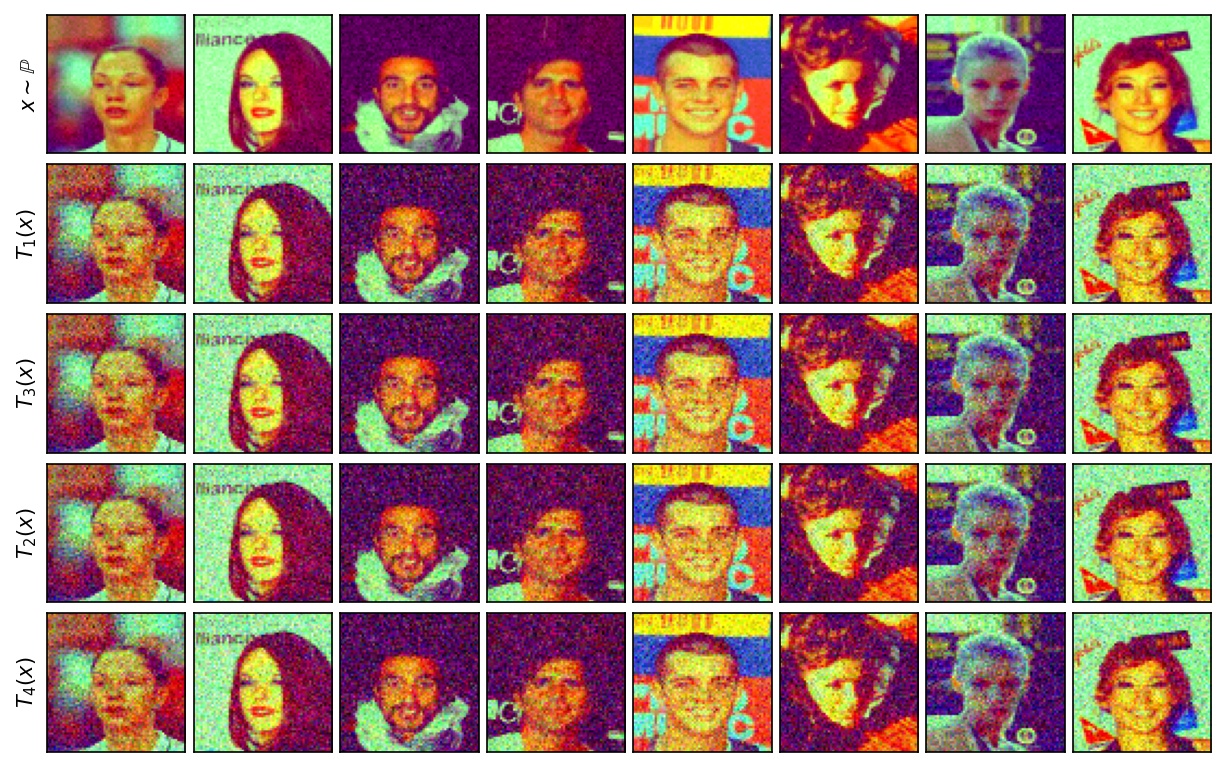

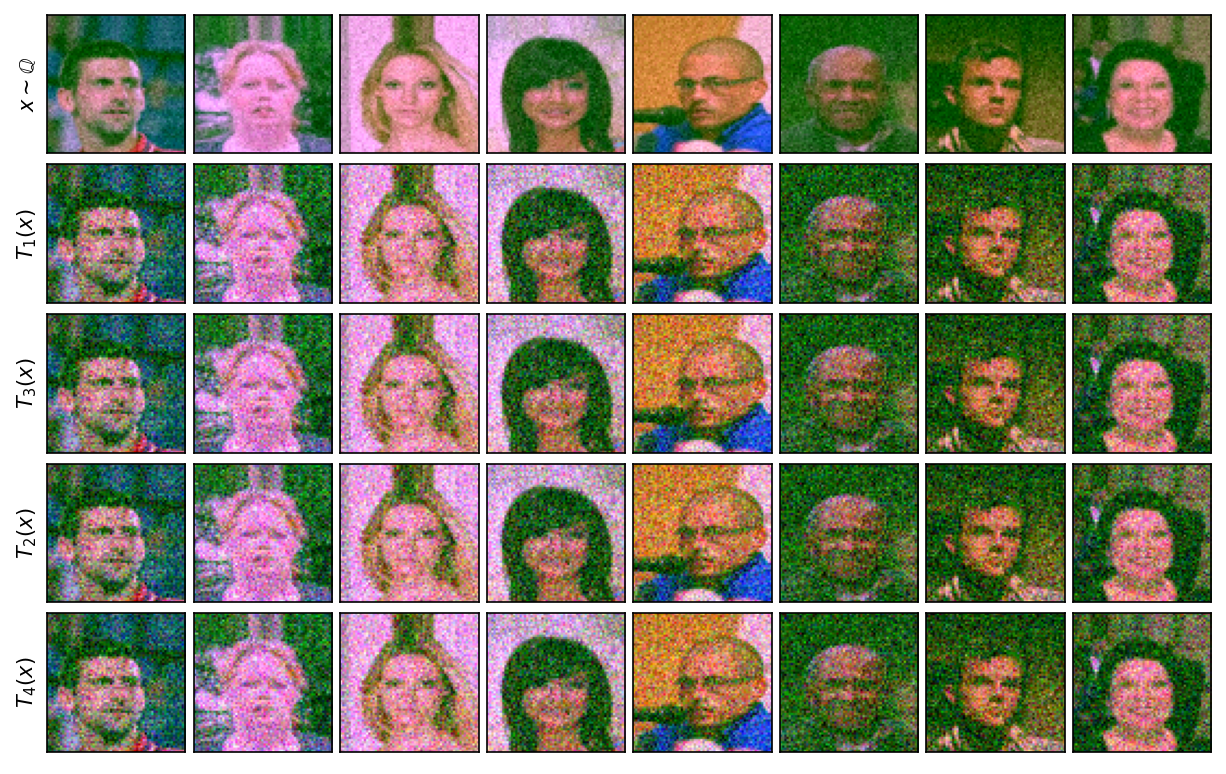

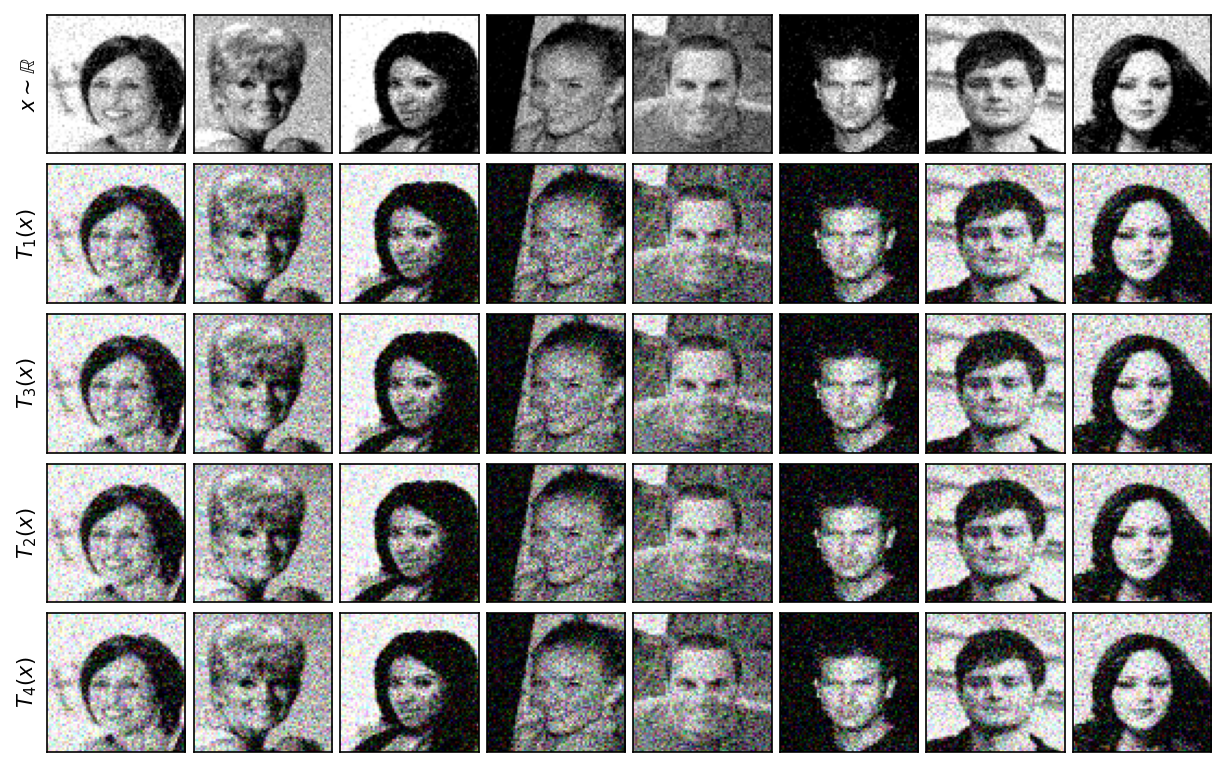

100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


In [100]:
SMDS = StatsManagerDrawScheduler(StatsManager('loss'), 1, 1, (5, 4), epoch_freq=20)

for step in tqdm(range(CONFIG.MAX_STEPS)):
    
    
    for idx in range(len(CONFIG.CLASSES)):
        unfreeze(f1[idx])
        
    X1 = data_samplers[0].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    X2 = data_samplers[1].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    X3 = data_samplers[2].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    
    Y1_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    Y2_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    Y3_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    
    
    for idx in range(len(CONFIG.CLASSES)):
        freeze(f1[idx])  
    with torch.no_grad():
        Y1 = sample_langevin_mu_f(lambda x:  f_pots[0](x), X1, Y1_init, CONFIG)
        Y3 = sample_langevin_mu_f(lambda x:  f_pots[2](x), X3, Y3_init, CONFIG)
        Y2 = sample_langevin_mu_f(lambda x:  f_pots[1](x), X2, Y2_init, CONFIG)
         
    for idx in range(len(CONFIG.CLASSES)):
        unfreeze(f1[idx]) 
    
    if CONFIG.FLAG_F_G_LATENT:
        loss = CONFIG.ALPHAS_BARYCENTER[0]*f_pots[0]( normalize_out_to_0_1(G(Y1,c=None)) ).mean() + CONFIG.ALPHAS_BARYCENTER[1]*f_pots[1](normalize_out_to_0_1(G(Y2,c=None)) ).mean() +\
    + CONFIG.ALPHAS_BARYCENTER[2]*f_pots[2](normalize_out_to_0_1(G(Y3,c=None))  ).mean()
    else:
        loss = CONFIG.ALPHAS_BARYCENTER[0]*f_pots[0]( Y1 ).mean() + CONFIG.ALPHAS_BARYCENTER[1]*f_pots[1](Y2).mean() +\
    + CONFIG.ALPHAS_BARYCENTER[2]*f_pots[2]( Y3  ).mean()
        
    
    f1_opt.zero_grad(); loss.backward(); f1_opt.step()
    SMDS.SM.upd('loss', loss.item())
    SMDS.epoch()
    wandb.log({"loss train":loss.item()},step=step)
    
    with torch.no_grad():
        
        if step % 10 == 0:
            cost_0 = 0.5 * torch.flatten(  Y1  - X1,
                                   start_dim=1).pow(2).sum(dim=1, keepdim=True)
            cost_1 = 0.5 * torch.flatten(  Y2  - X2,
                                   start_dim=1).pow(2).sum(dim=1, keepdim=True)
            cost_2 = 0.5 * torch.flatten(  Y3  - X3,
                                   start_dim=1).pow(2).sum(dim=1, keepdim=True)
            
            wandb.log({"Transport by cost 0": cost_0.mean().item()},step=step)
            wandb.log({"Transport by cost 1": cost_1.mean().item()},step=step)
            wandb.log({"Transport by cost 2": cost_2.mean().item()},step=step)
        
        if step % 50 == 0:
            N_ESTIMATE_POINTS = 8
            X1 = data_samplers[0].sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
            X2 = data_samplers[1].sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
            X3 = data_samplers[2].sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
            
            for idx in range(len(CONFIG.CLASSES)):
                    freeze(f1[idx]) 
                    
            map_1 = []
            map_2 = []
            map_3 = []
            for run in range(CONFIG.NUM_TEST_RUNS):
                Y1_init  = init_noise_sampler.sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE) 
                Y2_init =  init_noise_sampler.sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
                Y3_init =  init_noise_sampler.sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
                Y1 = sample_langevin_mu_f(lambda x:  f_pots[0](x), X1, Y1_init, CONFIG)
                Y3 = sample_langevin_mu_f(lambda x:  f_pots[2](x), X3, Y3_init, CONFIG)
                Y2 = sample_langevin_mu_f(lambda x:  f_pots[1](x), X2, Y2_init, CONFIG)

                map_1.append( Y1 );map_2.append( Y2 );map_3.append( Y3 )
            
                    
            plot_barycenter_map_in_data_space_more(X1,X2,X3,map_1,map_2,map_3,step=step,n_estimate_points=8)
            
        if step % 200 == 0:
            
            for idx in range(len(CONFIG.CLASSES)):
                    freeze(f1[idx]) 
                    
            for k in range(CONFIG.K):
                torch.save(f1[k].cpu().state_dict(), os.path.join("/trinity/home/a.kolesov/",
           "Averaging-with-Energy-A-Generic-Algorithm-for-Continuous-Entropic-Barycenter-Estimation/",
           "ckpts/",
           f"Ave_celeba_barycenter_in_data_space/step_{step}_net_{k}_{name_exp}.pth")
          )
            
            for k in range(CONFIG.K):
                f1[k].to(CONFIG.DEVICE)
              
